# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
run_training = True
run_training_of_comparison_networks = False #this take quite a long time (~6 times longer then main model)
run_test = True

In [2]:
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name="/Users/magdalena.zastawnik-gula/Documents/Courses/udacity/deep-reinforcement-learning/p1_navigation/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
def test_random_agent():
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    
    print("Score: {}".format(score))

In [7]:
#test_random_agent()

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [8]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [9]:
BUFFER_SIZE = int(1e7)  # replay buffer size    1e5
BATCH_SIZE = 64         # minibatch size      64
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

HIDDEN_LAYER_IN = 64
HIDDEN_LAYER_OUT = 64



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#REUSED CODE FROM DQN EXAMPLE

class Agent():

    def __init__(self, state_size, action_size, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed, HIDDEN_LAYER_IN, HIDDEN_LAYER_OUT).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, HIDDEN_LAYER_IN, HIDDEN_LAYER_OUT).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:

def dqn(n_episodes=5000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    total_score = [(0,0)]
    av_score = []
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            total_score.append((i_episode, score + total_score[-1][-1]))
            av_score.append((i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=16.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, total_score, av_score


### Train Basic Configuration

In [11]:
if run_training:
    HIDDEN_LAYER_IN = 64
    HIDDEN_LAYER_OUT = 64

    BUFFER_SIZE = int(1e5)  # replay buffer size    1e5
    BATCH_SIZE = 64         # minibatch size      64
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score, total_score, av_score = dqn()



Episode 100	Average Score: 1.31
Episode 200	Average Score: 4.71
Episode 300	Average Score: 8.46
Episode 400	Average Score: 10.79
Episode 500	Average Score: 12.60
Episode 600	Average Score: 14.22
Episode 700	Average Score: 14.54
Episode 800	Average Score: 14.94
Episode 900	Average Score: 15.77
Episode 1000	Average Score: 15.78
Episode 1100	Average Score: 15.56
Episode 1200	Average Score: 15.52
Episode 1300	Average Score: 14.67
Episode 1400	Average Score: 15.98
Episode 1500	Average Score: 15.90
Episode 1525	Average Score: 16.54
Environment solved in 1425 episodes!	Average Score: 16.54


#### Plot model score

17 17


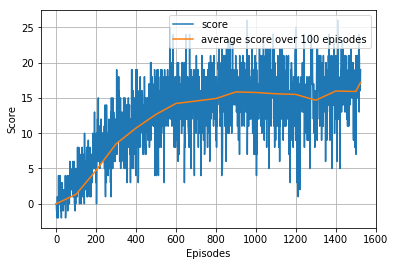

In [12]:
if run_training:
    x_label = range(len(score))
    ave = []
    x_ave = []
    suma = 0
    for item in x_label:
        suma += score[item]
        if item % 100 == 0:
            ave.append(suma/100)
            x_ave.append(item)
            suma = 0
    if suma != 0:
        ave.append(suma / (item % 100))
        x_ave.append(item)
        
    plt.plot(x_label, score, x_ave, ave)
    plt.legend(("score", "average score over 100 episodes"),
           loc='upper right')
    print (len(ave), len(x_ave))
    plt.ylabel('Score')
    plt.xlabel('Episodes')
    plt.grid(True)
    plt.show()
    #plt.savefig('plot_score_with_MR_10_10.png', dpi=199)

### Testing Different Buffer Size

In [13]:
if run_training_of_comparison_networks:
    BUFFER_SIZE = int(1e3)  # replay buffer size    1e3
    BATCH_SIZE = 64
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_1, total_score_1, av_score_1 = dqn()


    BUFFER_SIZE = int(1e7)  # replay buffer size    1e7
    BATCH_SIZE = 64
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_2, total_score_2, av_score_2 = dqn()

### Testing Different Batch Size

In [14]:
if run_training_of_comparison_networks:

    BUFFER_SIZE = int(1e5)
    BATCH_SIZE = 256         # minibatch size      256
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_4, total_score_4, av_score_4 = dqn()
    
    BUFFER_SIZE = int(1e5)
    BATCH_SIZE = 128         # minibatch size      128
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_3, total_score_3, av_score_3 = dqn()
    
    BUFFER_SIZE = int(1e5)
    BATCH_SIZE = 16         # minibatch size      16
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_4, total_score_4, av_score_4 = dqn()

    BUFFER_SIZE = int(1e5)
    BATCH_SIZE = 8         # minibatch size      8
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_5, total_score_5, av_score_5 = dqn()



### Testing Different NN Layer Size

In [15]:
if run_training_of_comparison_networks:    
    BUFFER_SIZE = int(1e5)  # replay buffer size    1e5
    BATCH_SIZE = 64         # minibatch size      64

    HIDDEN_LAYER_IN = 32
    HIDDEN_LAYER_OUT = 32
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_7, total_score_7, av_score_7 = dqn()
    
    HIDDEN_LAYER_IN = 64
    HIDDEN_LAYER_OUT = 32
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_6, total_score_6, av_score_6 = dqn()


    HIDDEN_LAYER_IN = 128
    HIDDEN_LAYER_OUT = 64
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_8, total_score_8, av_score_8 = dqn()


    HIDDEN_LAYER_IN = 128
    HIDDEN_LAYER_OUT = 128
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)
    score_9, total_score_9, av_score_9 = dqn()

In [16]:
def dqn_test(n_episodes=1, max_t=1000):

    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0
    for t in range(max_t):
        action = agent.act(state, 0)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        state = next_state
        score += reward
        if done:
            break 
    print(score)
    return score

In [17]:
if run_test:
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    dqn_test()

20.0


## Close environment

In [18]:
env.close()

In [20]:
writer = tf.summary.FileWriter("/Users/magdalena.zastawnik-gula/Documents/Courses/udacity/deep-reinforcement-learning/p1_navigation",)
writer.add_graph(sees.graph)

NameError: name 'tf' is not defined